Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install kaggle
!pip install imbalanced-learn
!pip install scikeras --upgrade
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score

Uploading and Previewing Dataset-
https://www.kaggle.com/datasets/hrithikpm/air-pollution-dataset-for-delhi

In [2]:
from google.colab import files
uploaded=files.upload()

Saving Delhi.xlsx to Delhi.xlsx


Cleaning the dataset

In [3]:
df=pd.read_excel('Delhi.xlsx',engine='openpyxl')
#handling the missing values
df.replace(-200,np.nan,inplace=True)
#dropping empty columns
df.dropna(axis=1,how='all',inplace=True)
#checking for missing values
print(df.isnull().sum())
#replacing missing values by average
df.fillna(df.mean(numeric_only=True),inplace=True)
print(df)
#checking for missing values
print(df.isnull().sum())
#converting 'From Date' and 'To Date' columns into Datetime type
df['From Date']=pd.to_datetime(df['From Date'], format='%d-%m-%Y %H:%M')
df['To Date']=pd.to_datetime(df['To Date'], format='%d-%m-%Y %H:%M')
#Calculating Duration from the Datetime columns
df['Duration'] = df['To Date'] - df['From Date']
print(df[['From Date','To Date','Duration']])
#saving the dataset
df.to_csv('cleaned_Delhi.csv',index=False,sep=';',decimal=',')
print('Dataset has been cleaned and saved successfully.')
print(df)

From Date      0
To Date        0
PM2.5         97
PM10         111
NO           112
NO2          111
CO           148
SO2          112
dtype: int64
             From Date           To Date   PM2.5    PM10      NO         NO2  \
0     01-02-2018 00:00  02-02-2018 00:00  193.92  440.44  108.37  339.270000   
1     02-02-2018 00:00  03-02-2018 00:00  128.64  331.54   84.83  230.520000   
2     03-02-2018 00:00  04-02-2018 00:00  104.89  256.50   80.84  203.930000   
3     04-02-2018 00:00  05-02-2018 00:00  135.79  276.49   89.40  245.110000   
4     05-02-2018 00:00  06-02-2018 00:00  178.25  415.84  117.69  305.670000   
...                ...               ...     ...     ...     ...         ...   
2025  19-08-2023 00:00  20-08-2023 00:00   59.07  174.46   30.73    2.300000   
2026  20-08-2023 00:00  21-08-2023 00:00   44.30  121.93   27.91   82.969844   
2027  21-08-2023 00:00  22-08-2023 00:00   48.46  179.27   27.58   19.770000   
2028  22-08-2023 00:00  23-08-2023 00:00   54.08  2

Calculating AQI and their class labels from the given parameters in the dataset

In [4]:
# Define breakpoint tables for each pollutant
breakpoints = {
    'PM2.5': [
        (0, 30, 0, 50),
        (31, 60, 51, 100),
        (61, 90, 101, 200),
        (91, 120, 201, 300),
        (121, 250, 301, 400),
        (251, 500, 401, 500),
    ],
    'PM10': [
        (0, 50, 0, 50),
        (51, 100, 51, 100),
        (101, 250, 101, 200),
        (251, 350, 201, 300),
        (351, 430, 301, 400),
        (431, 600, 401, 500),
    ],
    'NO': [  # Estimate based on similar ranges to NO2
        (0, 50, 0, 50),
        (51, 100, 51, 100),
        (101, 200, 101, 200),
        (201, 400, 201, 300),
        (401, 800, 301, 400),
        (801, 1000, 401, 500),
    ],
    'NO2': [
        (0, 40, 0, 50),
        (41, 80, 51, 100),
        (81, 180, 101, 200),
        (181, 280, 201, 300),
        (281, 400, 301, 400),
        (401, 800, 401, 500),
    ],
    'SO2': [
        (0, 40, 0, 50),
        (41, 80, 51, 100),
        (81, 380, 101, 200),
        (381, 800, 201, 300),
        (801, 1600, 301, 400),
        (1601, 2100, 401, 500),
    ],
    'CO': [
        (0.0, 1.0, 0, 50),
        (1.1, 2.0, 51, 100),
        (2.1, 10.0, 101, 200),
        (10.1, 17.0, 201, 300),
        (17.1, 34.0, 301, 400),
        (34.1, 50.0, 401, 500),
    ]
}

# AQI calculation function
def calculate_sub_index(concentration, pollutant):
    for bp_low, bp_high, i_low, i_high in breakpoints[pollutant]:
        if bp_low <= concentration <= bp_high:
            # Apply the AQI formula
            sub_index = ((i_high - i_low) / (bp_high - bp_low)) * (concentration - bp_low) + i_low
            return round(sub_index)
    return None  # If value is outside known breakpoints

# Main AQI calculation function using all pollutants
def calculate_aqi(data):
    sub_indices = {}
    for pollutant in ['PM2.5', 'PM10', 'NO', 'NO2', 'SO2', 'CO']:
        value = data.get(pollutant)
        if value is not None:
            sub_index = calculate_sub_index(value, pollutant)
            sub_indices[pollutant] = sub_index
    # Final AQI is the maximum sub-index
    aqi_value = max(sub_indices.values())
    return aqi_value, sub_indices

# --- Function to calculate AQI for one row ---
def compute_aqi_for_row(row):
    sub_indices = []
    for pollutant in breakpoints.keys():
        value = row.get(pollutant)
        if pd.notnull(value):
            sub_index = calculate_sub_index(value, pollutant)
            if sub_index is not None:
                sub_indices.append(sub_index)
    if sub_indices:
        return max(sub_indices)  # AQI is the max of sub-indices
    else:
        return None

df = pd.read_csv('cleaned_Delhi.csv',sep=';',decimal=',',engine='python')
#Applingy AQI calculation to all rows
df['AQI'] = df.apply(compute_aqi_for_row, axis=1)
#Creating AQI category
def classify_aqi(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Satisfactory'
    elif aqi <= 200:
        return 'Moderate'
    elif aqi <= 300:
        return 'Poor'
    elif aqi <= 400:
        return 'Very Poor'
    else:
        return 'Severe'

df['AQI_Category'] = df['AQI'].apply(classify_aqi)
#Save updated dataset
df.to_csv('updated_delhi_dataset.csv', index=False)
print("AQI calculation complete.Sample data:")
print(df[['PM2.5', 'PM10', 'NO', 'NO2', 'SO2', 'CO', 'AQI_Category']])




AQI calculation complete.Sample data:
       PM2.5    PM10      NO         NO2    SO2    CO  AQI_Category
0     193.92  440.44  108.37  339.270000  13.78  4.08        Severe
1     128.64  331.54   84.83  230.520000  16.49  2.23     Very Poor
2     104.89  256.50   80.84  203.930000  17.58  4.11          Poor
3     135.79  276.49   89.40  245.110000  15.00  6.36     Very Poor
4     178.25  415.84  117.69  305.670000  14.23  2.17     Very Poor
...      ...     ...     ...         ...    ...   ...           ...
2025   59.07  174.46   30.73    2.300000  14.46  1.88      Moderate
2026   44.30  121.93   27.91   82.969844  14.24  0.75      Moderate
2027   48.46  179.27   27.58   19.770000  18.49  0.87      Moderate
2028   54.08  260.82   44.72   14.260000  15.27  1.11          Poor
2029   30.33   87.09   39.78   15.990000  14.03  1.23  Satisfactory

[2030 rows x 7 columns]


Plotting the different class labels

   AQI AQI_Category
0  407       Severe
1  307    Very Poor
2  248         Poor
3  312    Very Poor
4  382    Very Poor


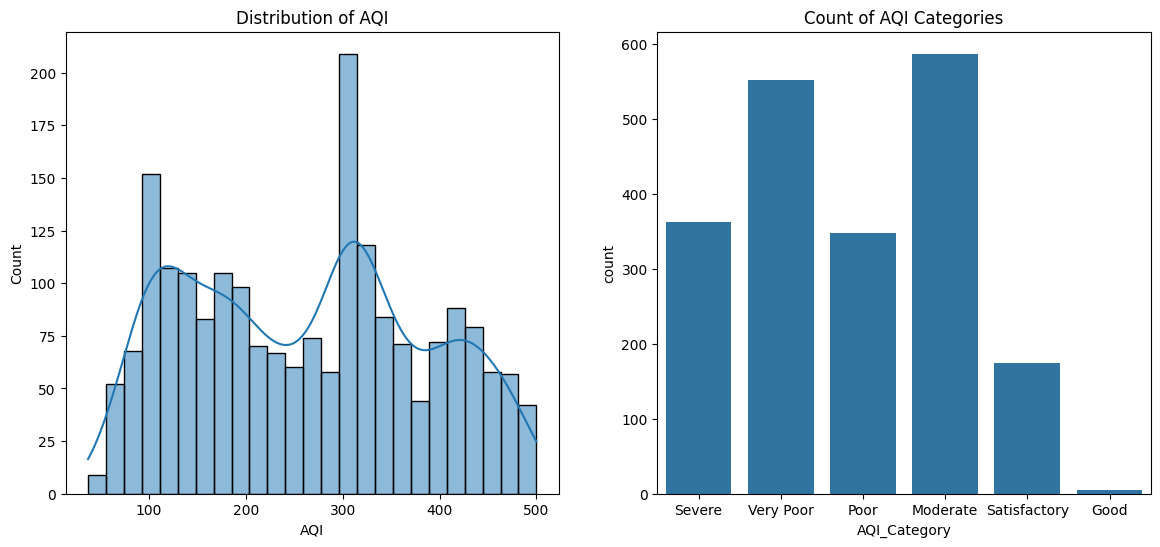

In [5]:
# Plot histogram and category count
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
sns.histplot(df['AQI'], bins=25,kde=True)
plt.title('Distribution of AQI')

plt.subplot(1, 2, 2)

print(df[['AQI', 'AQI_Category']].head())

sns.countplot(x='AQI_Category', data=df)
plt.title("Count of AQI Categories")
plt.show()

Data Preprocessing:Encoding,Feature Extraction and Scaling

  Feature  Importance
1    PM10    0.427077
0   PM2.5    0.371425
5      CO    0.066813
3     NO2    0.062830
2      NO    0.047307
4     SO2    0.024548


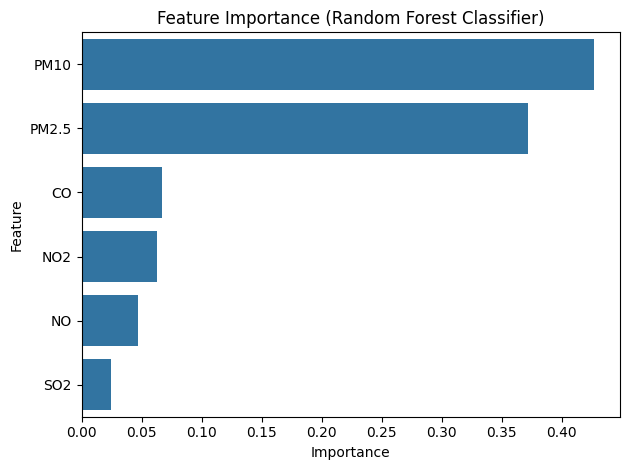

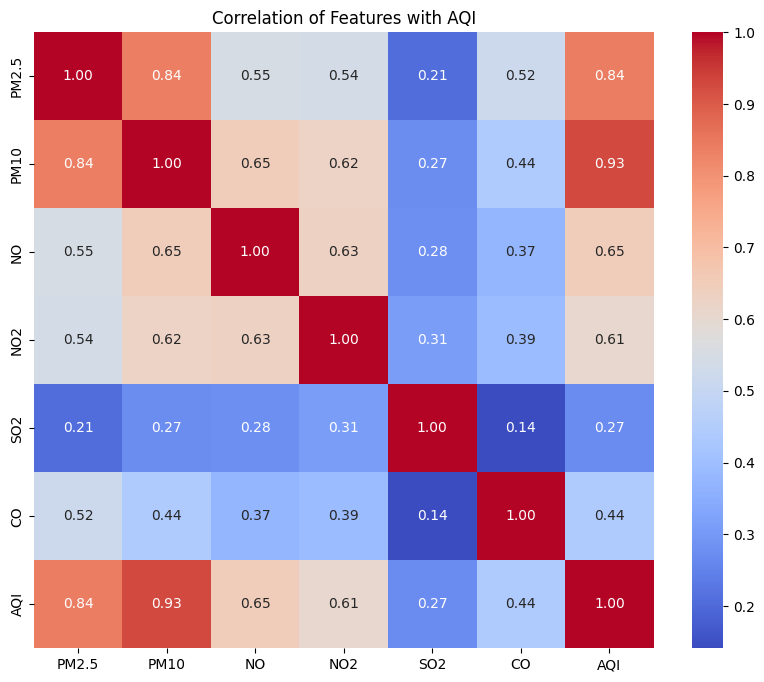

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3435 - loss: 1.6764 - val_accuracy: 0.5015 - val_loss: 1.3797
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5067 - loss: 1.3078 - val_accuracy: 0.5908 - val_loss: 1.1528
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6016 - loss: 1.0817 - val_accuracy: 0.6523 - val_loss: 1.0057
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6425 - loss: 0.9842 - val_accuracy: 0.6831 - val_loss: 0.9201
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6791 - loss: 0.8849 - val_accuracy: 0.7108 - val_loss: 0.8429
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7096 - loss: 0.7901 - val_accuracy: 0.7323 - val_loss: 0.7815
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7007 - loss: 0.7287 - val_accuracy: 0.7446 - val_loss: 0.7476
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7622 - loss: 0.7395 - val_accuracy: 0.7538 - val_loss: 0.7237
Ep

In [6]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the updated dataset with AQI_Category
df = pd.read_csv('updated_delhi_dataset.csv')

# Define features and target
feature_cols = ['PM2.5','PM10', 'NO', 'NO2', 'SO2', 'CO']
X = df[feature_cols]
y = df['AQI_Category']  # Categorical AQI labels like 'Good', 'Moderate', etc.

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Feature scaling
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_encoded, test_size=0.2, random_state=42)

# Random Forest for feature importance
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(x_train, y_train)
importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# Plot feature importances
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance (Random Forest Classifier)')
plt.tight_layout()
plt.show()

# Correlation heatmap (optional)
corr_matrix = df[feature_cols + ['AQI']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation of Features with AQI')
plt.show()

# Build TensorFlow Neural Network for Classification
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))  # Output layer for classification

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Updated formula for AQI calculation

In [7]:
import pandas as pd

# Load your dataset
df = pd.read_csv('updated_delhi_dataset.csv',sep=',',decimal='.',engine='python')
print(df.columns)
#Define the Sub-Index Calculation Function
def calculate_subindex(Cp, breakpoints):
    for bp_lo, bp_hi, I_lo, I_hi in breakpoints:
        if bp_lo <= Cp <= bp_hi:
            return ((I_hi - I_lo) / (bp_hi - bp_lo)) * (Cp - bp_lo) + I_lo
    return None  # If value out of range

#Define CPCB Breakpoints for Each Pollutant

# PM2.5 (µg/m³)
pm25_breakpoints = [
    (0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200),
    (91, 120, 201, 300), (121, 250, 301, 400), (251, 500, 401, 500)
]

# PM10 (µg/m³)
pm10_breakpoints = [
    (0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200),
    (251, 350, 201, 300), (351, 430, 301, 400), (431, 600, 401, 500)
]

# CO (mg/m³)
co_breakpoints = [
    (0, 1, 0, 50), (1, 2, 51, 100), (2, 10, 101, 200),
    (10, 17, 201, 300), (17, 34, 301, 400), (34, 50, 401, 500)
]

# NO2 (µg/m³)
no2_breakpoints = [
    (0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),
    (181, 280, 201, 300), (281, 400, 301, 400), (401, 500, 401, 500)
]

# Apply Sub-Index Calculations to Dataset
df['PM2.5_SubIndex'] = df['PM2.5'].apply(lambda x: calculate_subindex(x, pm25_breakpoints))
df['PM10_SubIndex'] = df['PM10'].apply(lambda x: calculate_subindex(x, pm10_breakpoints))
df['CO_SubIndex'] = df['CO'].apply(lambda x: calculate_subindex(x, co_breakpoints))
df['NO2_SubIndex'] = df['NO2'].apply(lambda x: calculate_subindex(x, no2_breakpoints))


# Compute Final AQI (Maximum of Sub-Indices)
df['AQI'] = df[['PM2.5_SubIndex', 'PM10_SubIndex', 'CO_SubIndex', 'NO2_SubIndex']].max(axis=1)

# Classify AQI Levels
def classify_aqi(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Satisfactory'
    elif aqi <= 200:
        return 'Moderate'
    elif aqi <= 300:
        return 'Poor'
    elif aqi <= 400:
        return 'Very Poor'
    else:
        return 'Severe'

df['AQI_Category'] = df['AQI'].apply(classify_aqi)

# Save or Display
df.to_csv('AQI_calculated_dataset.csv', index=False)
print(df[['PM2.5', 'PM10', 'CO', 'NO2', 'AQI', 'AQI_Category']])

Index(['From Date', 'To Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'CO', 'SO2',
       'Duration', 'AQI', 'AQI_Category'],
      dtype='object')
       PM2.5    PM10    CO         NO2         AQI  AQI_Category
0     193.92  440.44  4.08  339.270000  406.529941        Severe
1     128.64  331.54  2.23  230.520000  306.863256     Very Poor
2     104.89  256.50  4.11  203.930000  248.417586          Poor
3     135.79  276.49  6.36  245.110000  312.350465     Very Poor
4     178.25  415.84  2.17  305.670000  382.255190     Very Poor
...      ...     ...   ...         ...         ...           ...
2025   59.07  174.46  1.88    2.300000  149.808993      Moderate
2026   44.30  121.93  0.75   82.969844  114.906510      Moderate
2027   48.46  179.27  0.87   19.770000  153.004899      Moderate
2028   54.08  260.82  1.11   14.260000  210.820000          Poor
2029   30.33   87.09  1.23   15.990000   87.090000  Satisfactory

[2030 rows x 6 columns]


Converting the labesl to One-hot Encodings

In [8]:
from sklearn.preprocessing import OneHotEncoder

y = df['AQI_Category'].values.reshape(-1, 1)

# Initialize encoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform labels
y_encoded = encoder.fit_transform(y)

# Optional: print the encoded class labels
print("Class labels:", encoder.categories_)

Class labels: [array(['Good', 'Moderate', 'Poor', 'Satisfactory', 'Severe', 'Very Poor'],
      dtype=object)]


Using SMOT technique to tackle the imbalance in the labels

In [9]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Encode labels (e.g., Good = 0, Moderate = 1, Unhealthy = 2)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print('Label mapping:')
for i,label in enumerate(le.classes_):
  print(f'{i}: {label}')

# Step 2: Split before resampling
feature_cols = ['PM2.5','PM10', 'NO', 'NO2', 'SO2', 'CO']
x = df[feature_cols]
y = df['AQI_Category']  # Categorical AQI labels like 'Good', 'Moderate', etc.

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)

# Step 3: Apply SMOTE to training data only
# Determine the minimum number of samples in any class in the training data
min_samples = min(Counter(y_train).values())

# Set k_neighbors for SMOTE to be at most the minimum number of samples minus 1 (if min_samples > 1) or 1 (if min_samples is 1)
k_neighbors_smote = max(1, min_samples -1 )

smote = SMOTE(random_state=42, k_neighbors=k_neighbors_smote)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))

# Step 4: Train KNeighborsClassifier
n_neighbors_knn = min(3, len(x_train_resampled))  # Ensure n_neighbors <= training samples
knn_model = KNeighborsClassifier(n_neighbors=n_neighbors_knn)
knn_model.fit(x_train_resampled, y_train_resampled)


# Step 4: One-hot encode y
from tensorflow.keras.utils import to_categorical
y_train_ohe = to_categorical(y_train_resampled)
y_test_ohe = to_categorical(y_test, num_classes=y_train_ohe.shape[1]) # Ensure the number of classes is consistent

print("Before encoding:", y_train[1100:1125])
print("After encoding:", y_train_ohe[1100:1125])

Label mapping:
0: Good
1: Moderate
2: Poor
3: Satisfactory
4: Severe
5: Very Poor
Before SMOTE: Counter({np.int64(1): 476, np.int64(5): 442, np.int64(4): 290, np.int64(2): 278, np.int64(3): 135, np.int64(0): 3})
After SMOTE: Counter({np.int64(3): 476, np.int64(1): 476, np.int64(2): 476, np.int64(5): 476, np.int64(4): 476, np.int64(0): 476})
Before encoding: [5 1 1 3 1 2 1 3 4 5 5 2 5 4 1 5 2 2 3 1 5 5 1 5 2]
After encoding: [[0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]]


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Plotting resampled categories

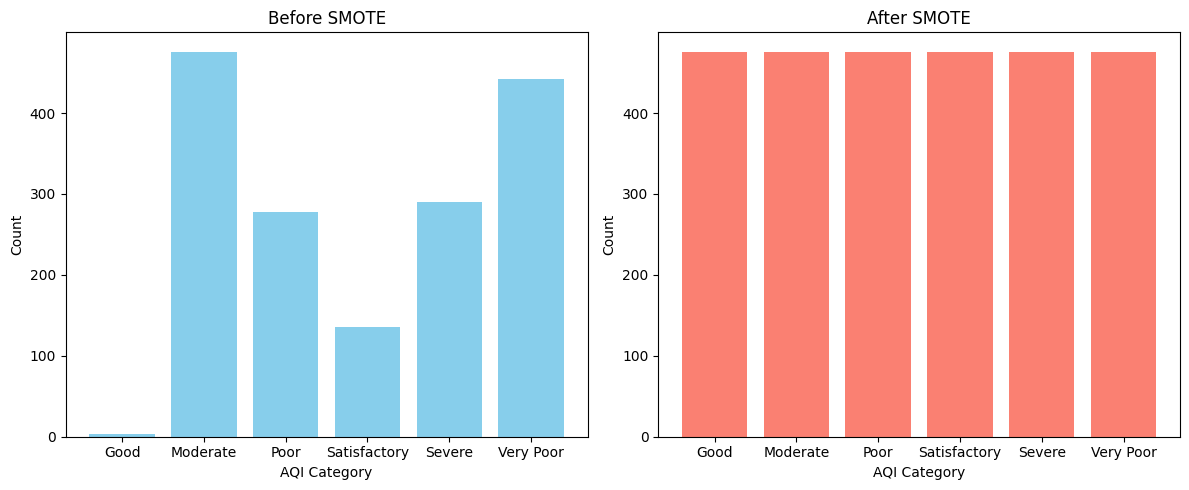

Before SMOTE:
AQI_Category
Moderate        595
Very Poor       552
Severe          363
Poor            347
Satisfactory    169
Good              4
Name: count, dtype: int64

After SMOTE:
3    476
1    476
2    476
5    476
4    476
0    476
Name: count, dtype: int64


In [10]:
import matplotlib.pyplot as plt
from collections import Counter

# Mapping back integer labels to original AQI_Level labels for visualization
label_names = le.classes_

# Count before and after resampling
before_counts = Counter(y_train)
after_counts = Counter(y_train_resampled)

# Create bar chart
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot before SMOTE
axs[0].bar(label_names, [before_counts[i] for i in range(len(label_names))], color='skyblue')
axs[0].set_title('Before SMOTE')
axs[0].set_xlabel('AQI Category')
axs[0].set_ylabel('Count')

# Plot after SMOTE
axs[1].bar(label_names, [after_counts[i] for i in range(len(label_names))], color='salmon')
axs[1].set_title('After SMOTE')
axs[1].set_xlabel('AQI Category')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

#plotting Original and resampled categories
print("Before SMOTE:")
print(y.value_counts())
print("\nAfter SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Building and Compiling the Model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
def create_model():
  model = Sequential([
    layers.Input(shape=(6,)),
    layers.Dense(units=64,activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(units=32,activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(units=16,activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(units=6,activation='softmax'),
  ])
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

Training the Model

In [12]:
model = create_model()
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train_resampled,y_train_ohe,epochs=100,batch_size=32,validation_split=0.2,verbose=1)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1973 - loss: 15.2959 - val_accuracy: 0.2570 - val_loss: 1.5134
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2415 - loss: 2.4979 - val_accuracy: 0.2010 - val_loss: 1.6061
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2717 - loss: 1.8702 - val_accuracy: 0.2185 - val_loss: 1.6191
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2655 - loss: 1.8106 - val_accuracy: 0.2098 - val_loss: 1.6366
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2932 - loss: 1.7237 - val_accuracy: 0.2255 - val_loss: 1.6706
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3202 - loss: 1.6434 - val_accuracy: 0.3427 - val_loss: 1.6485
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4065 - loss: 1.4810 - val_accuracy: 0.3042 - val_loss: 1.6806
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4237 - loss: 1.4109 - val_accuracy: 0.271

Evaluating the Model

In [13]:
from tensorflow.keras.models import load_model
loss, accuracy = model.evaluate(x_test, y_test_ohe)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7721 - loss: 0.7243 
Test Loss: 0.8220
Test Accuracy: 77.59%


Predict on Test Sets

In [14]:
y_pred_probs = model.predict(x_test)
y_pred_classes= y_pred_probs.argmax(axis=1)  # Converts one-hot or softmax to class index
y_test_classes= y_test_ohe.argmax(axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


Comparing Training and Testing Accuracies and Losses

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training Accuracy: 85.12%
Testing Accuracy: 77.59%


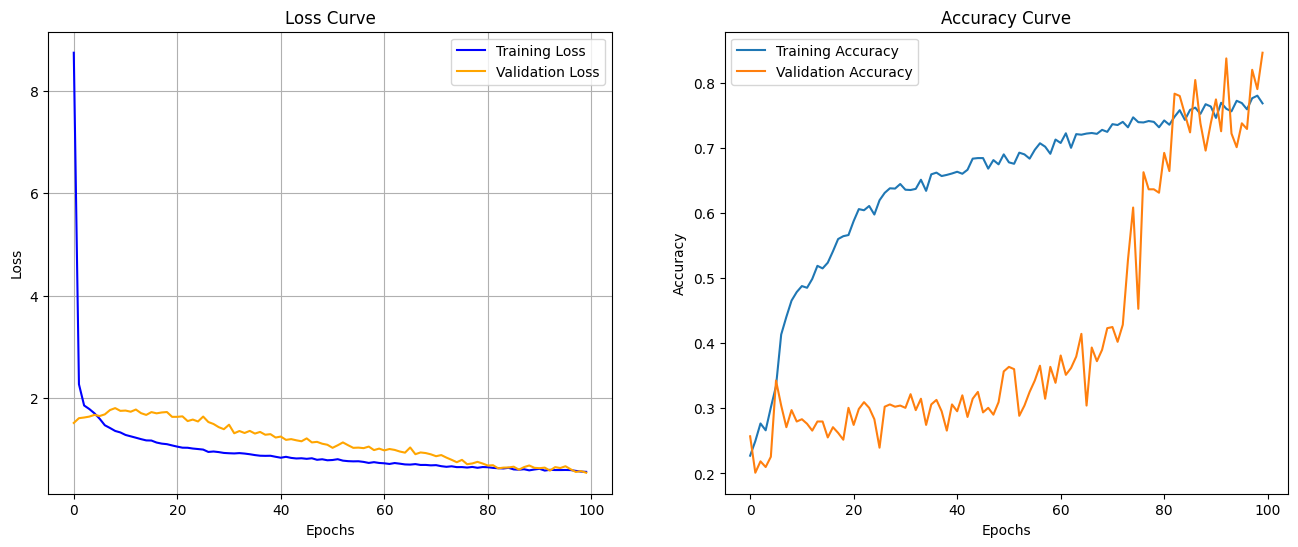

In [15]:
from sklearn.metrics import accuracy_score

#predict on training and testing dataset
y_train_pred=model.predict(x_train_resampled)
y_test_pred=model.predict(x_test)
#predict the training and testing classes
y_train_pred_classes=y_train_pred.argmax(axis=1)
y_test_pred_classes=y_test_pred.argmax(axis=1)
#calculating accuracy
train_acc=accuracy_score(y_train_ohe.argmax(axis=1),y_train_pred_classes)
test_acc=accuracy_score(y_test_ohe.argmax(axis=1),y_test_pred_classes)
print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Testing Accuracy: {test_acc * 100:.2f}%")

#plot
plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Displaying the Confusion Matrix

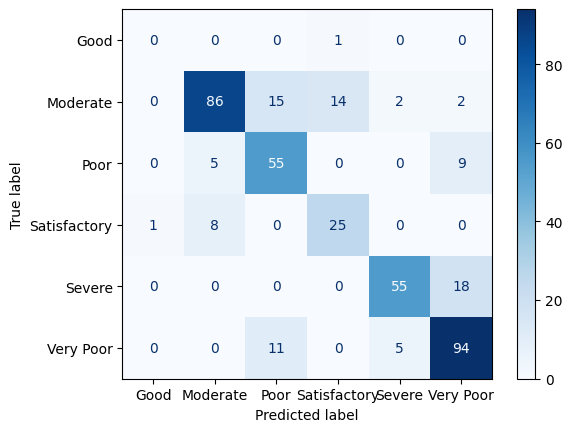

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder

# Re-encode y_test to get the correct dimensions for the confusion matrix
encoder = OneHotEncoder(sparse_output=False)
y_test_encoded =encoder.fit_transform(y_test.reshape(-1, 1))
y_test_classes = y_test_encoded.argmax(axis=1)
aqi_labels = ['Good', 'Moderate', 'Poor', 'Satisfactory', 'Severe', 'Very Poor']
cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=aqi_labels)
disp.plot(cmap='Blues')

Checking the Model

In [18]:
def test_model_with_input(model, X_test, y_test_encoded, input_values):
    import numpy as np

    # Predict on test set to calculate accuracy
    loss, accuracy = model.evaluate(x_test, y_test_encoded, verbose=0)
    print(f" Model Test Accuracy: {accuracy * 100:.2f}%")

    # Predict for custom input
    # Ensure input_values is a list of 6 values
    if len(input_values) != 6:
        print("Error: Please provide a list of 6 input values for PM2.5, PM10, NO, NO2, SO2, and CO.")
        return

    # Reshape input_values to match the model's expected input shape (1, 6)
    input_data = np.array([input_values])
    predicted_probs = model.predict(input_data)
    predicted_class_index = np.argmax(predicted_probs, axis=1)[0]

    # Define class labels (adjust if different) - Using the labels from the LabelEncoder in cell SBdel6QkekRw
    aqi_labels = ['Good', 'Moderate', 'Poor', 'Satisfactory', 'Severe', 'Very Poor']
    predicted_label = aqi_labels[predicted_class_index]

    print(f" Predicted AQI Category for input values {input_values}: {predicted_label}")

# Example usage with sample input values (replace with your desired values)
# The order of values should correspond to the feature_cols: ['PM2.5', 'PM10', 'NO', 'NO2', 'SO2', 'CO']
test_model_with_input(model, x_test, y_test_encoded, input_values=[50, 100, 40, 80, 40, 1.0])

 Model Test Accuracy: 77.59%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
 Predicted AQI Category for input values [50, 100, 40, 80, 40, 1.0]: Moderate


Classification Report

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification Report:
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00         1
    Moderate       0.87      0.72      0.79       119
        Poor       0.68      0.80      0.73        69
Satisfactory       0.62      0.74      0.68        34
      Severe       0.89      0.75      0.81        73
   Very Poor       0.76      0.85      0.81       110

    accuracy                           0.78       406
   macro avg       0.64      0.64      0.64       406
weighted avg       0.79      0.78      0.78       406



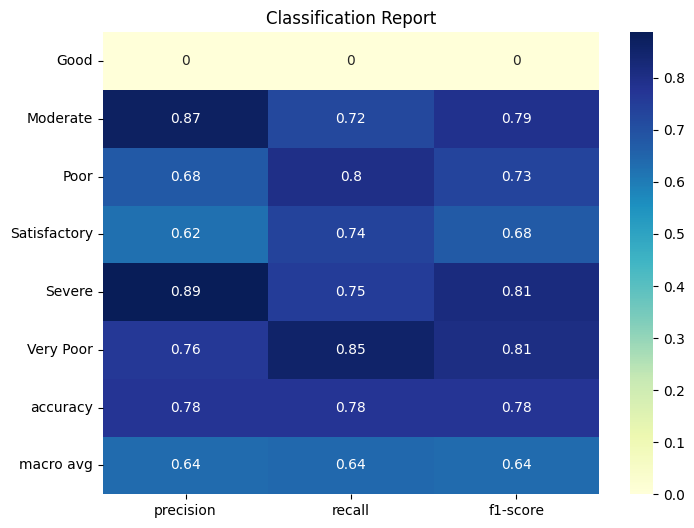

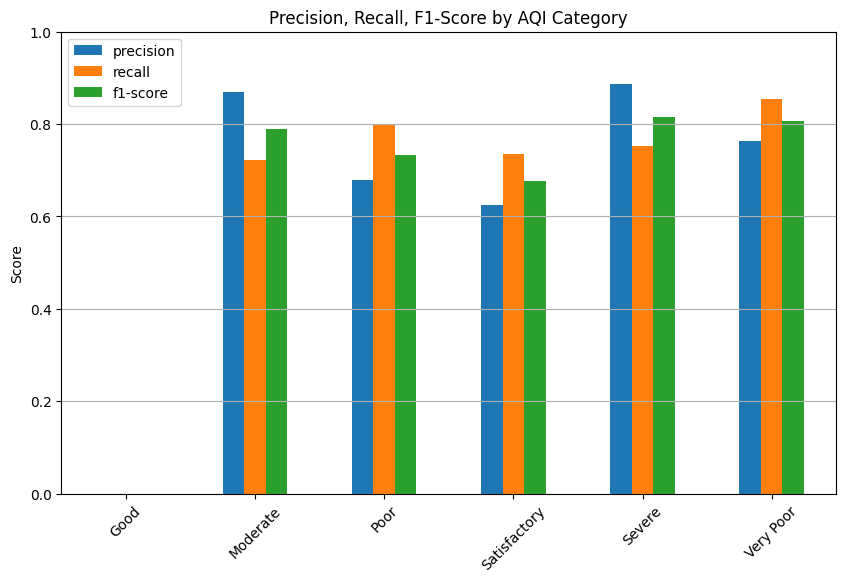

In [19]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(x_test)

# Get predicted class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get true class indices
# Assuming y_test_encoded is already available and correctly represents the true labels in one-hot encoding
y_true_classes = np.argmax(y_test_ohe, axis=1)

# Define class labels based on the LabelEncoder used previously
# These labels were printed in cell SBdel6QkekRw
aqi_labels = ['Good', 'Moderate', 'Poor', 'Satisfactory', 'Severe', 'Very Poor']

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=aqi_labels))

# Get the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=aqi_labels,output_dict=True)

# Convert to DataFrame for plotting
df_report = pd.DataFrame(report).transpose()
#plotting the Classification heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu")
plt.title("Classification Report")
plt.show()
# Plot precision, recall, f1-score
#Extract precision, recall, f1-score for each class
metrics_df = pd.DataFrame(report).transpose()
metrics_df = metrics_df.iloc[:6]  # Only class rows

metrics_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Precision, Recall, F1-Score by AQI Category')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.ylim(0, 1)
plt.show()


Extracting Feature Importance

In [28]:
from scikeras.wrappers import KerasClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
import numpy as np

# Define feature names
pollutant_cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'CO', 'SO2']
feature_names = pollutant_cols

# Create the Keras model
keras_model = create_model()

# Train the Keras model directly
keras_model.fit(x_train_resampled, y_train_ohe, epochs=20, batch_size=32, verbose=0)

# Define a custom scoring function for permutation importance
def custom_accuracy_scorer(estimator, X, y):
    y_pred_probs = estimator.predict(X)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y, axis=1)
    return accuracy_score(y_true_classes, y_pred_classes)


# Use the trained Keras model with the custom scorer for permutation importance
results = permutation_importance(keras_model, x_test, y_test_ohe, scoring=custom_accuracy_scorer)

for i in results.importances_mean.argsort()[::-1]:
    print(f"{feature_names[i]}: {results.importances_mean[i]:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
